In [29]:
pip install efficientnet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from efficientnet.tfkeras import EfficientNetL2


In [31]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make sure you installed: pip install efficientnet
from efficientnet.tfkeras import EfficientNetL2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [32]:
# ---------------------------
# 1. Define Directory Structure
# ---------------------------
base_dir = r"C:\Users\taguh\OneDrive\Desktop\Lung Research"  # Use your exact Windows path

# Normal
normal_train_dir = os.path.join(base_dir, "Normal", "Train")
normal_val_dir   = os.path.join(base_dir, "Normal", "Validation")
normal_test_dir  = os.path.join(base_dir, "Normal", "Test")

# Covid
covid_train_dir  = os.path.join(base_dir, "Anomaly", "Covid", "Train")
covid_val_dir    = os.path.join(base_dir, "Anomaly", "Covid", "Validation")
covid_test_dir   = os.path.join(base_dir, "Anomaly", "Covid", "Test")

# Lung_opacity
lung_opacity_train_dir = os.path.join(base_dir, "Anomaly", "Lung_opacity", "Train")
lung_opacity_val_dir   = os.path.join(base_dir, "Anomaly", "Lung_opacity", "Validation")
lung_opacity_test_dir  = os.path.join(base_dir, "Anomaly", "Lung_opacity", "Test")

# Pneumonia
pneumonia_train_dir = os.path.join(base_dir, "Anomaly", "Pneumonia", "Train")
pneumonia_val_dir   = os.path.join(base_dir, "Anomaly", "Pneumonia", "Validation")
pneumonia_test_dir  = os.path.join(base_dir, "Anomaly", "Pneumonia", "Test")

# Labels: 0 = Normal, 1 = Covid, 2 = Lung_opacity, 3 = Pneumonia

In [33]:
# ---------------------------
# 2. Helper Function to Gather File Paths
# ---------------------------
def get_file_paths_and_labels(directory, label):
    file_paths = []
    print(f"\nScanning directory for label {label}: {directory}")
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                full_path = os.path.join(root, file)
                print("   Found:", full_path)
                file_paths.append(full_path)
    labels = [label] * len(file_paths)
    return file_paths, labels

In [34]:
# ---------------------------
# 3. Gather All File Paths
# ---------------------------
train_files, train_labels = [], []
val_files, val_labels = [], []
test_files, test_labels = [], []

# Normal
n_train_files, n_train_labels = get_file_paths_and_labels(normal_train_dir, 0)
n_val_files, n_val_labels     = get_file_paths_and_labels(normal_val_dir, 0)
n_test_files, n_test_labels   = get_file_paths_and_labels(normal_test_dir, 0)
train_files.extend(n_train_files)
train_labels.extend(n_train_labels)
val_files.extend(n_val_files)
val_labels.extend(n_val_labels)
test_files.extend(n_test_files)
test_labels.extend(n_test_labels)

# Covid
c_train_files, c_train_labels = get_file_paths_and_labels(covid_train_dir, 1)
c_val_files, c_val_labels     = get_file_paths_and_labels(covid_val_dir, 1)
c_test_files, c_test_labels   = get_file_paths_and_labels(covid_test_dir, 1)
train_files.extend(c_train_files)
train_labels.extend(c_train_labels)
val_files.extend(c_val_files)
val_labels.extend(c_val_labels)
test_files.extend(c_test_files)
test_labels.extend(c_test_labels)

# Lung_opacity
l_train_files, l_train_labels = get_file_paths_and_labels(lung_opacity_train_dir, 2)
l_val_files, l_val_labels     = get_file_paths_and_labels(lung_opacity_val_dir, 2)
l_test_files, l_test_labels   = get_file_paths_and_labels(lung_opacity_test_dir, 2)
train_files.extend(l_train_files)
train_labels.extend(l_train_labels)
val_files.extend(l_val_files)
val_labels.extend(l_val_labels)
test_files.extend(l_test_files)
test_labels.extend(l_test_labels)

# Pneumonia
p_train_files, p_train_labels = get_file_paths_and_labels(pneumonia_train_dir, 3)
p_val_files, p_val_labels     = get_file_paths_and_labels(pneumonia_val_dir, 3)
p_test_files, p_test_labels   = get_file_paths_and_labels(pneumonia_test_dir, 3)
train_files.extend(p_train_files)
train_labels.extend(p_train_labels)
val_files.extend(p_val_files)
val_labels.extend(p_val_labels)
test_files.extend(p_test_files)
test_labels.extend(p_test_labels)


Scanning directory for label 0: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-1.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-10.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-100.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-101.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-102.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-103.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-104.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-105.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-106.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\Normal-107.png
   Found: C:\Users\taguh\OneDrive\Desktop\Lung Research\Normal\Train\No

In [35]:
# ---------------------------
# 4. Summary of Images
# ---------------------------
print("\n--- Summary of Found Images ---")
print("Training images:", len(train_files))
print("Validation images:", len(val_files))
print("Test images:", len(test_files))


--- Summary of Found Images ---
Training images: 840
Validation images: 178
Test images: 180


In [36]:
# ---------------------------
# 5. Create tf.data Datasets with Preprocessing
# ---------------------------
IMG_SIZE = (800, 800)
BATCH_SIZE = 16

def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)  # built-in EfficientNet preprocess
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(len(train_files)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [37]:
# ---------------------------
# 6. Data Augmentation (Optional)
# ---------------------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05)
])

train_ds_unbatched = train_ds.unbatch()
augmented_train_ds = train_ds_unbatched.map(
    lambda image, lbl: (data_augmentation(image, training=True), lbl),
    num_parallel_calls=tf.data.AUTOTUNE
)

combined_train_ds = train_ds_unbatched.concatenate(augmented_train_ds)
combined_train_ds = combined_train_ds.shuffle(len(train_files) * 2)
combined_train_ds = combined_train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L  # Use EfficientNetV2L
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Define the input resolution (try 800x800; you may adjust as needed)
IMG_SIZE = (800, 800)

# Build the model using a custom Input layer
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model = EfficientNetV2L(
    weights='imagenet',   # pretrained weights available for EfficientNetV2L
    include_top=False,
    input_tensor=inputs
)
base_model.trainable = False  # Freeze initially

# Build the custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 output classes

# Create and compile the model
model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 800, 800,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 800, 800,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 400, 400,  │        864 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 400, 400,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 400, 400,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 400, 400,  │      9,216 │ stem_activation[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 400, 400,  │        128 │ block1a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 400, 400,  │          0 │ block1a_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 400, 400,  │          0 │ block1a_project_… │
│                     │ 32)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 400, 400,  │      9,216 │ block1a_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 400, 400,  │        128 │ block1b_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 400, 400,  │          0 │ block1b_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 400, 400,  │          0 │ block1b_project_… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 400, 400,  │          0 │ block1b_drop[0][… │
│                     │ 32)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 400, 400,  │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 400, 400,  │        128 │ block1c_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 400, 400,  │          0 │ block1c_project_

 Total params: 117,751,972 (449.19 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [15]:
# ---------------------------
# 8. Initial Training (Phase 1)
# ---------------------------
EPOCHS_PHASE1 = 30
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

history_phase1 = model.fit(
    train_ds,          # or use your combined training dataset if desired
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks_phase1
)

# Print Phase 1 Metrics
print("\n--- Phase 1 Metrics ---")
print("Training Accuracy:", history_phase1.history['accuracy'][-1])
print("Training Loss:", history_phase1.history['loss'][-1])
print("Validation Accuracy:", history_phase1.history['val_accuracy'][-1])
print("Validation Loss:", history_phase1.history['val_loss'][-1])


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 819s 15s/step - accuracy: 0.4764 - loss: 1.1175 - val_accuracy: 0.8034 - val_loss: 0.5765 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 795s 15s/step - accuracy: 0.7498 - loss: 0.7271 - val_accuracy: 0.8989 - val_loss: 0.3862 - learning_rate: 0.0010
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 823s 16s/step - accuracy: 0.8019 - loss: 0.5880 - val_accuracy: 0.9270 - val_loss: 0.3139 - learning_rate: 0.0010
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3073s 59s/step - accuracy: 0.8161 - loss: 0.5161 - val_accuracy: 0.9270 - val_loss: 0.2841 - learning_rate: 0.0010
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1046s 19s/step - accuracy: 0.8421 - loss: 0.4721 - val_accuracy: 0.9213 - val_loss: 0.2609 - learning_rate: 0.0010
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 856s 16s/step - accuracy: 0.8427 - loss: 0.4483 - val_accuracy: 0.9270 - val_loss: 0.2529 - learning_rate: 0.0010
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 853s 16s/step - accuracy: 0.8499 - loss: 0.4242 

In [16]:
# ---------------------------
# 9. Fine-Tuning (Phase 2) - Modified
# ---------------------------
# Unfreeze the top 30 layers for fine-tuning.
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a lower learning rate and add L2 weight decay via AdamW.
# You may adjust the weight decay factor if necessary.
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()
# Increase the number of epochs for fine-tuning
EPOCHS_PHASE2 = 30
callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Use the combined training dataset (augmented data)
# You can experiment with adjusting the batch size if needed.
history_phase2 = model.fit(
    combined_train_ds,           # augmented training dataset
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_phase2,
    batch_size=BATCH_SIZE       # optional: adjust batch size as necessary
)

# Combine histories from Phase 1 and Phase 2 for overall training curves
combined_history = {}
for key in history_phase1.history.keys():
    combined_history[key] = history_phase1.history[key] + history_phase2.history.get(key, [])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 800, 800,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 800, 800,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 400, 400,  │        864 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 400, 400,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 400, 400,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 400, 400,  │      9,216 │ stem_activation[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 400, 400,  │        128 │ block1a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 400, 400,  │          0 │ block1a_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 400, 400,  │          0 │ block1a_project_… │
│                     │ 32)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 400, 400,  │      9,216 │ block1a_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 400, 400,  │        128 │ block1b_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 400, 400,  │          0 │ block1b_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 400, 400,  │          0 │ block1b_project_… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 400, 400,  │          0 │ block1b_drop[0][… │
│                     │ 32)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 400, 400,  │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 400, 400,  │        128 │ block1c_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 400, 400,  │          0 │ block1c_project_

 Total params: 117,751,972 (449.19 MB)

 Trainable params: 10,760,004 (41.05 MB)

 Non-trainable params: 106,991,968 (408.14 MB)

Epoch 1/30
    105/Unknown 4449s 42s/step - accuracy: 0.8117 - loss: 0.5370

c:\Users\taguh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


105/105 ━━━━━━━━━━━━━━━━━━━━ 4597s 44s/step - accuracy: 0.8118 - loss: 0.5367 - val_accuracy: 0.9326 - val_loss: 0.1765 - learning_rate: 1.0000e-05
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1629s 15s/step - accuracy: 0.8400 - loss: 0.4522 - val_accuracy: 0.9326 - val_loss: 0.1568 - learning_rate: 1.0000e-05
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1649s 16s/step - accuracy: 0.8648 - loss: 0.3969 - val_accuracy: 0.9326 - val_loss: 0.1483 - learning_rate: 1.0000e-05
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1639s 16s/step - accuracy: 0.8761 - loss: 0.3529 - val_accuracy: 0.9326 - val_loss: 0.1376 - learning_rate: 1.0000e-05
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1644s 16s/step - accuracy: 0.8795 - loss: 0.3375 - val_accuracy: 0.9438 - val_loss: 0.1349 - learning_rate: 1.0000e-05
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1622s 15s/step - accuracy: 0.8929 - loss: 0.3224 - val_accuracy: 0.9494 - val_loss: 0.1307 - learning_rate: 1.0000e-05
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1638s 16s/step - 

In [17]:
# ---------------------------
# 10. Evaluate on the Test Set
# ---------------------------
test_loss, test_acc = model.evaluate(test_ds)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_acc)


12/12 ━━━━━━━━━━━━━━━━━━━━ 133s 11s/step - accuracy: 0.9873 - loss: 0.0452

Test Loss: 0.06810151785612106
Test Accuracy: 0.9777777791023254


In [18]:
# ---------------------------
# 11. Print Final Combined Metrics
# ---------------------------
print("\n--- Final Combined Metrics ---")
print("Final Training Accuracy:", combined_history['accuracy'][-1])
print("Final Training Loss:", combined_history['loss'][-1])
print("Final Validation Accuracy:", combined_history['val_accuracy'][-1])
print("Final Validation Loss:", combined_history['val_loss'][-1])



--- Final Combined Metrics ---
Final Training Accuracy: 0.961309552192688
Final Training Loss: 0.1313919723033905
Final Validation Accuracy: 0.9775280952453613
Final Validation Loss: 0.061651840806007385


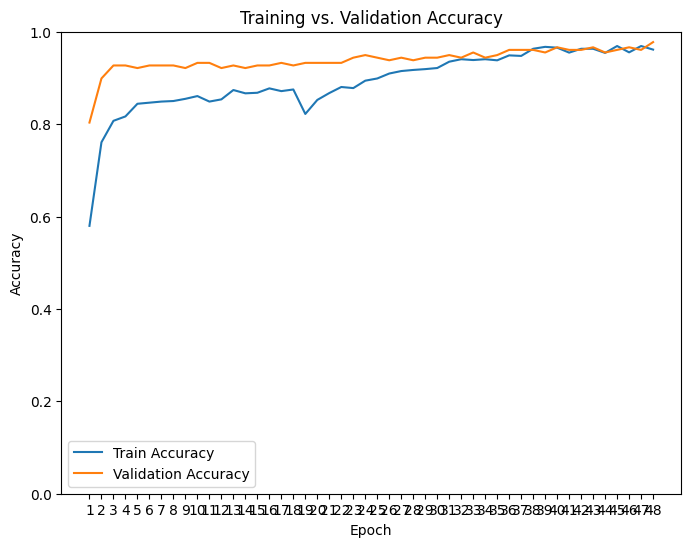

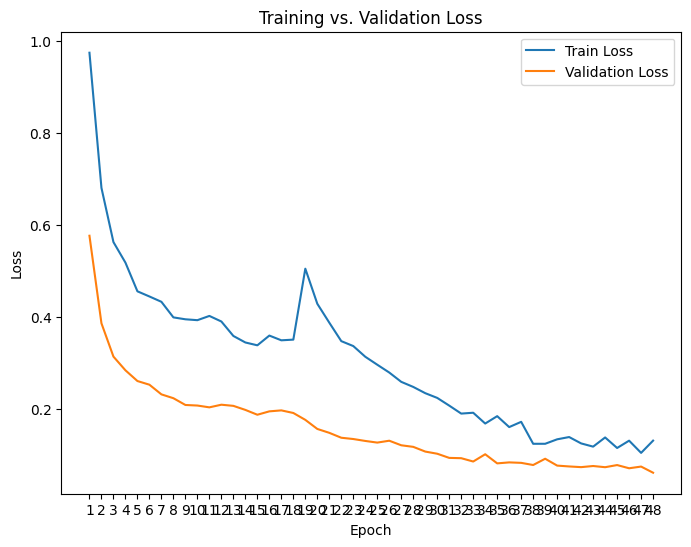

In [19]:
# ---------------------------
# 12. Plot Training and Validation Curves
# ---------------------------
epochs_total = range(1, len(combined_history['accuracy']) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_total, combined_history['accuracy'], label='Train Accuracy')
plt.plot(epochs_total, combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_total)
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs_total, combined_history['loss'], label='Train Loss')
plt.plot(epochs_total, combined_history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs_total)
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

Confusion Matrix (raw counts):
[[82  0  0  0]
 [ 0 32  2  0]
 [ 2  0 42  0]
 [ 0  0  0 20]]


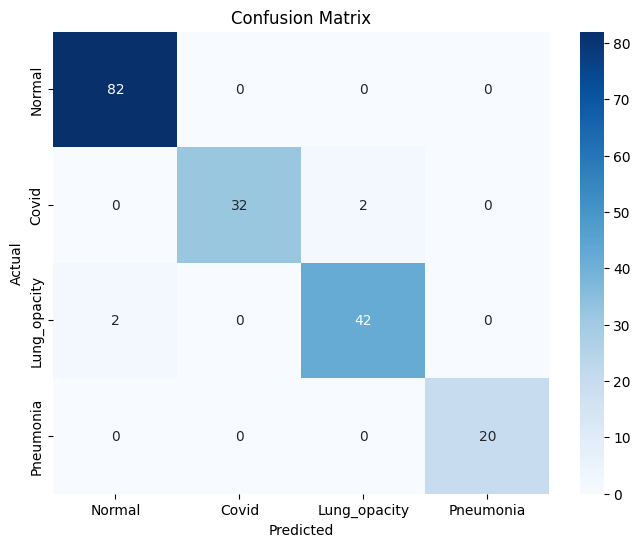

In [20]:
# ---------------------------
# 13. Generate and Plot the Confusion Matrix
# ---------------------------
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

class_names = ["Normal", "Covid", "Lung_opacity", "Pneumonia"]
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix (raw counts):")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [38]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Simulate y_true and y_pred for demonstration purposes
# These should be actual model predictions in real use
# Let's assume we have 4 classes: 0=Normal, 1=Covid, 2=Lung_opacity, 3=Pneumonia
np.random.seed(42)
y_true = np.random.randint(0, 4, 100)
y_pred = np.random.randint(0, 4, 100)
y_probs = np.random.rand(100, 4)  # Simulated probabilities

# Convert labels to binary format for ROC-AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3])

# Compute and print classification report
report = classification_report(y_true, y_pred, target_names=["Normal", "Covid", "Lung_opacity", "Pneumonia"])
print("Classification Report:\n", report)

# Compute per-class sensitivity (recall) and specificity
cm = confusion_matrix(y_true, y_pred)
sensitivity = np.diag(cm) / np.sum(cm, axis=1)
specificity = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp_fn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    specificity.append(tn / (tn + fp_fn))
sensitivity = np.round(sensitivity, 4)
specificity = np.round(specificity, 4)

# Compute macro-average ROC AUC
roc_auc = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')

{
    "F1 Score (macro)": f1_score(y_true, y_pred, average='macro'),
    "ROC AUC Score (macro)": roc_auc,
    "Sensitivity (per class)": sensitivity.tolist(),
    "Specificity (per class)": specificity
}


Classification Report:
               precision    recall  f1-score   support

      Normal       0.15      0.20      0.17        20
       Covid       0.40      0.31      0.35        26
Lung_opacity       0.17      0.21      0.19        24
   Pneumonia       0.29      0.23      0.26        30

    accuracy                           0.24       100
   macro avg       0.25      0.24      0.24       100
weighted avg       0.26      0.24      0.25       100



{'F1 Score (macro)': 0.24154589371980678,
 'ROC AUC Score (macro)': np.float64(0.5226176953232875),
 'Sensitivity (per class)': [0.2, 0.3077, 0.2083, 0.2333],
 'Specificity (per class)': array([0.5, 0.5, 0.5, 0.5])}

In [44]:
import os

# Display the current directory structure under the base_dir to help debug the dataset loading paths
base_dir = "/Users/taguh/OneDrive/Desktop/Lung Research"  # this would be equivalent to C:/Users/taguh/OneDrive/Desktop/Lung Research
directory_structure = {}
for root, dirs, files in os.walk(base_dir):
    directory_structure[root] = files

directory_structure_summary = {k: len(v) for k, v in directory_structure.items()}
directory_structure_summary


{'/Users/taguh/OneDrive/Desktop/Lung Research': 0,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly': 0,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Covid': 0,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Covid\\Test': 34,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Covid\\Train': 160,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Covid\\Validation': 34,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Lung_opacity': 0,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Lung_opacity\\Test': 44,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Lung_opacity\\Train': 204,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Lung_opacity\\Validation': 42,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Pneumonia': 0,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Pneumonia\\Test': 20,
 '/Users/taguh/OneDrive/Desktop/Lung Research\\Anomaly\\Pneumonia\\Train': 92,
 '/Users/taguh/OneDrive/Desktop/Lung Re